En primer lugar se len los datos del archivo, corrigiendo el formato de separacion, de ';' a ','.

In [284]:
import pandas as pd

raw_dataset = pd.read_csv('Calidad_de_agus_2023.csv', delimiter=';')

raw_dataset

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,42,Balneario Municipal,BS094,23/8/2023,2023,invierno,12,13,9.41,8.67,...,2.3,66,75,<0.10,<0.005,<0.001,19.25,<0.15,36,Extremadamente deteriorada
165,42,Playa La Balandra,BS093,22/2/2023,2023,Verano,20,23,5.8,7.47,...,3.4,58,17,<0.10,<0.005,<0.001,<0.10,>5.00,no se pudo calcular,NaN
166,42,Playa La Balandra,BS093,10/5/2023,2023,otoño,18,13,5.93,8.35,...,2.10,<30,32.00,<0.10,<0.005,<1.0,54.87,<0.15,36,Extremadamente deteriorada
167,42,Playa La Balandra,BS093,14/11/2023,2023,primavera,20,14,8.22,8.30,...,<2.0,48,110,<0.10,0,<0.001,37.4,<0.15,35,Extremadamente deteriorada


Hacemos un head para ver de que tratan los datos.

In [285]:
raw_dataset.head()

,orden,sitios,codigo,fecha,año,campaña,tem_agua,tem_aire,od,ph,...,dbo_mg_l,dqo_mg_l,turbiedad_ntu,hidr_deriv_petr_ug_l,cr_total_mg_l,cd_total_mg_l,clorofila_a_ug_l,microcistina_ug_l,ica,calidad_de_agua
0,1,Canal Villanueva y Río Luján,TI001,22/2/2023,2023,Verano,26,24,6.59,7.24,...,<2.0,<30,29,<0.10,<0.005,<0.001,0.87,<0.15,53,Muy deteriorada
1,1,Canal Villanueva y Río Luján,TI001,10/5/2023,2023,otoño,18,12,7.09,7.22,...,<2.0,<30,45.00,<0.10,<0.005,<1.0,2.56,<0.15,39,Extremadamente deteriorada
2,1,Canal Villanueva y Río Luján,TI001,23/8/2023,2023,invierno,16.3,11,8.53,7.27,...,<2.0,<30,38,<0.10,<0.005,<0.001,1.02,<0.15,48,Muy deteriorada
3,1,Canal Villanueva y Río Luján,TI001,14/11/2023,2023,primavera,23,25,4.72,6.57,...,<2.0,<30,24,<0.10,<0.005,<0.001,<10.00,<0.15,42,Extremadamente deteriorada
4,2,Río Lujan y Arroyo Caraguatá,TI006,22/2/2023,2023,Verano,26.8,25,5.94,6.96,...,2.1,<30,24,<0.10,<0.005,<0.001,10.61,0.21,39,Extremadamente deteriorada


Borramos las columas orden, codigo y año ya que no aportan nada al analisis.

In [286]:
raw_dataset = raw_dataset.drop('orden', axis=1)
raw_dataset = raw_dataset.drop('codigo', axis=1)
raw_dataset = raw_dataset.drop('año', axis=1)


Ahora en busca de nulos por columna.

In [287]:
raw_dataset.isna().sum()

sitios                      0
fecha                       0
campaña                     0
tem_agua                    0
tem_aire                    0
od                          0
ph                          1
olores                      0
color                       0
espumas                     0
mat_susp                    0
colif_fecales_ufc_100ml     0
escher_coli_ufc_100ml       0
enteroc_ufc_100ml           0
nitrato_mg_l                0
nh4_mg_l                    0
p_total_l_mg_l              1
fosf_ortofos_mg_l           0
dbo_mg_l                    1
dqo_mg_l                    0
turbiedad_ntu               0
hidr_deriv_petr_ug_l        0
cr_total_mg_l               0
cd_total_mg_l               0
clorofila_a_ug_l            0
microcistina_ug_l           0
ica                         1
calidad_de_agua            15
dtype: int64

Vemos en cada una de las columnas que valores toman.

In [288]:
#se revisa una por una las columnas
#lo que esta entre corchetes se fue cambiando entre todas las variables para ver que valores aparecen

for idx, val in raw_dataset["olores"].value_counts().items():
  print(idx, val)

Ausencia 140
Presencia 11
no muestreó 7
en obra 4
no se muestreó 4
inaccesible 2
no se midió 1


Remplazamos por nulos los valores que no nos interesan, es decir, no nos aportan informacion relevante.

In [289]:
import pandas as pd

# Copiar el dataset
preprocessed_dataset = raw_dataset.copy()

# Lista de valores a reemplazar por pd.NA
valores_a_reemplazar = ['sin equipo', 'no muestreó', 'no se midió', 'en obra', 'no se muestreó',
                        'inaccesible', 'sin muestra', 'envase sin muestra', 'falto un frasco',
                        'Dato atípico', 'no se pudo calcular', 'N/R', 'no funcionó', '-', 'N/A', '', ' ']

# Lista de columnas a las que se les debe aplicar el reemplazo
columnas_a_procesar = [
    'tem_agua', 'tem_aire', 'od', 'ph', 'olores', 'color', 'espumas', 'mat_susp', 
    'colif_fecales_ufc_100ml', 'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 
    'nitrato_mg_l', 'nh4_mg_l', 'p_total_l_mg_l', 'fosf_ortofos_mg_l', 
    'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu', 'hidr_deriv_petr_ug_l', 'cr_total_mg_l',
    'cd_total_mg_l', 'clorofila_a_ug_l', 'microcistina_ug_l', 'ica', 'calidad_de_agua'
]

# Recorrer todas las columnas y aplicar el reemplazo
for columna in columnas_a_procesar:
    preprocessed_dataset[columna] = preprocessed_dataset[columna].replace(valores_a_reemplazar, pd.NA)


Ahora vamos a borrar aquellas filas que quedaron con muchos nulos, ya que no nos van a servir para el analisis. Estas filas borradas son aquellas con mas de 23 valores nulos, que corresponden a las muestras donde no se realizaron observaciones.

In [290]:

preprocessed_dataset = preprocessed_dataset.dropna(thresh=len(preprocessed_dataset.columns) - 23)

Luego definimos las columnas que van a ser de tipo cuantitativos y de fecha, eliminando los simbolos "<" o ">" en los valores que los porten.

In [291]:
columnas_a_convertir = ['tem_agua', 'tem_aire', 'od', 'ph', 'colif_fecales_ufc_100ml',
                         'escher_coli_ufc_100ml', 'enteroc_ufc_100ml', 'nitrato_mg_l', 'nh4_mg_l',
                         'p_total_l_mg_l', 'fosf_ortofos_mg_l', 'dbo_mg_l', 'dqo_mg_l', 'turbiedad_ntu',
                         'hidr_deriv_petr_ug_l', 'cr_total_mg_l', 'cd_total_mg_l', 'clorofila_a_ug_l',
                         'microcistina_ug_l', 'ica']

for col in columnas_a_convertir:
    preprocessed_dataset[col] = preprocessed_dataset[col].str.replace('<', '').str.replace('>', '')
    preprocessed_dataset[col] = pd.to_numeric(preprocessed_dataset[col])

preprocessed_dataset['fecha'] = pd.to_datetime(preprocessed_dataset['fecha'], format="%d/%m/%Y")

Transformamos el tipo de dato de determinadas columnas para poder trabajar con las variables cualitativas.

In [292]:
#Transformacion campaña
preprocessed_dataset['campaña']=preprocessed_dataset['campaña'].replace(['Verano','otoño','invierno','primavera'],['0','1','2','3'])

#transformacion olores, color, espumas,mat_susp
preprocessed_dataset['olores']=preprocessed_dataset['olores'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['color']=preprocessed_dataset['color'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['espumas']=preprocessed_dataset['espumas'].replace(['Ausencia','Presencia'],['0','1'])
preprocessed_dataset['mat_susp']=preprocessed_dataset['mat_susp'].replace(['Ausencia','Presencia'],['0','1'])

#transformacion calidad_de_agua
preprocessed_dataset['calidad_de_agua']=preprocessed_dataset['calidad_de_agua'].replace(['Muy deteriorada','Muy deteriorada ','Extremadamente deteriorada'],['0','0','1'])

columnas_cualitativas = ['campaña', 'olores', 'color', 'espumas', 'mat_susp', 'calidad_de_agua']
preprocessed_dataset[columnas_cualitativas] = preprocessed_dataset[columnas_cualitativas].apply(pd.to_numeric, errors='coerce')

Analizamos el porcentaje de nulos en cada columna para ver si las eliminabamos. Como en ninguna de las columnas hay presencia de nulos mayor o igual al 60% las conservamos.

In [293]:
columnas_totales = columnas_a_convertir.copy()
columnas_totales.extend(columnas_cualitativas)

for col in columnas_totales:
    if ((preprocessed_dataset[col].isna().sum() / len(preprocessed_dataset[col]))*100 >= 60):
        print(col)

De acuerdo a la columna, realizamos imputaciones con la tecnica de los n vecinos mas cercanos, eligiendo los dos mas cercanos, para suprimir los valores nulos restantes.

No sabemos si esto es correcto al no haber analizado los mecanismos de datos faltantes, por desconcer el dominio del problema.

In [294]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors = 2, weights = "uniform")


preprocessed_dataset_imputado = preprocessed_dataset[columnas_totales]
dataset_imputado = imputer.fit_transform(preprocessed_dataset_imputado)

preprocessed_dataset[columnas_totales] = dataset_imputado

Bueno tenemos ya un dataset completo y sin nulos, ideal para empezar a trabajar en el analisis. En el dataset podemos observar tres variables que son indicadoras de contaminacion fecal y estan medidas en las mismas unidades. Veamos un analisis bivariado que nos muestre como se relacionan entre ellas.

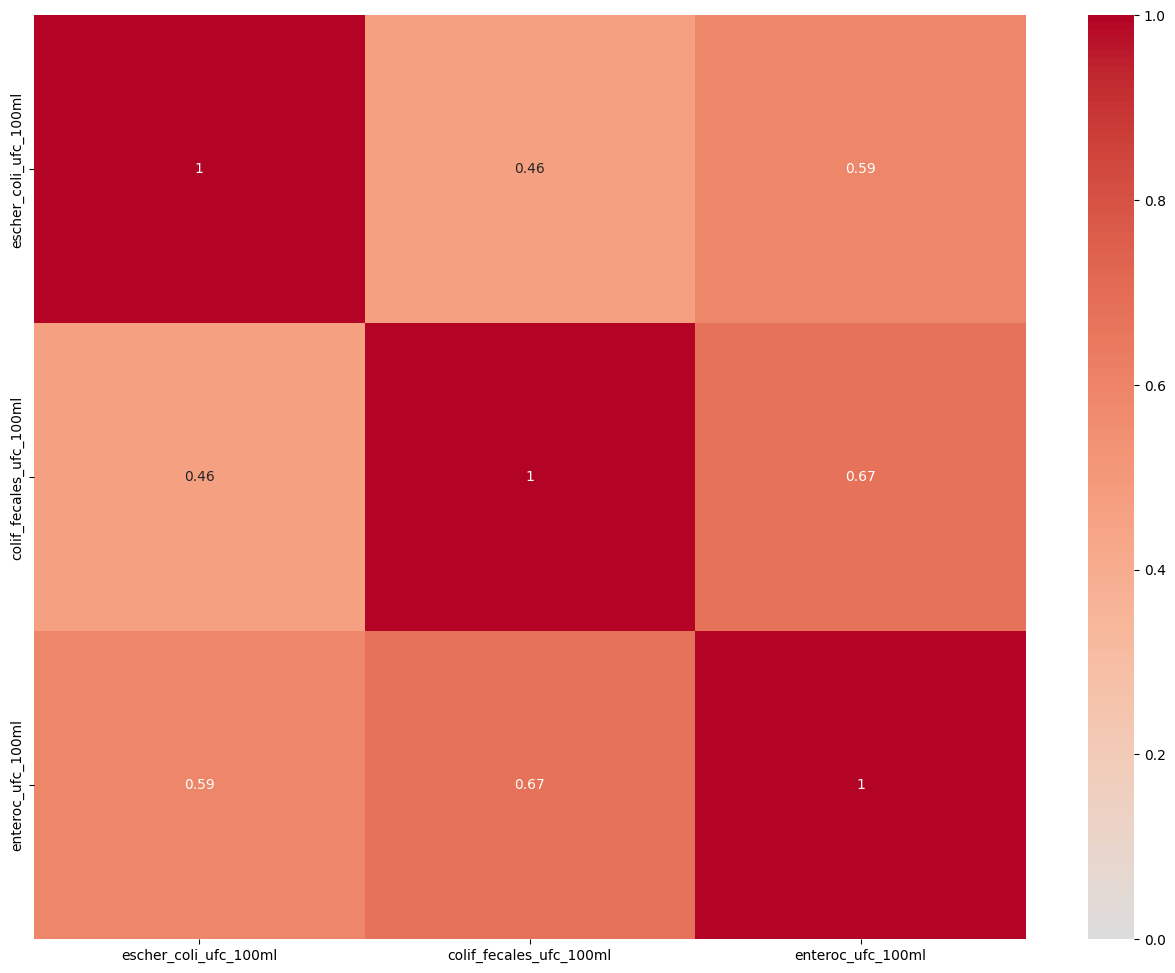

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

caca = ['escher_coli_ufc_100ml', 'colif_fecales_ufc_100ml', 'enteroc_ufc_100ml']

var_cont_fecal = preprocessed_dataset[caca]

bivariado_corr = var_cont_fecal
correlation_matrix = bivariado_corr.corr()

plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, vmin=0.0, vmax=1.0, center=0.0, annot=True, cmap= 'coolwarm')
plt.show()

Como podemos observar estas variables que representan lo mismo, estan lejos de presentar una correlacion positiva fuerte, que es lo que mas tendria sentido. Veamos que esta pasando con estas tres variables, hagamos los scaters plots entre ellas.

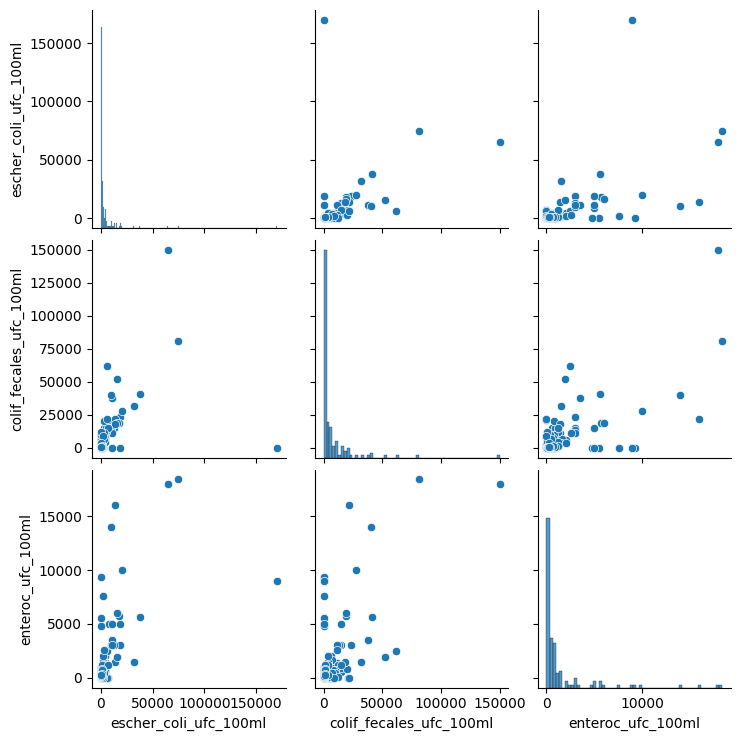

In [296]:
sns.pairplot(var_cont_fecal[caca])
plt.show()

Podemos observar un outlier muy feo en el caso de 'escher_coli_ufc_100ml'. Toma un valor muy grande. Veamoslo en un histograma.

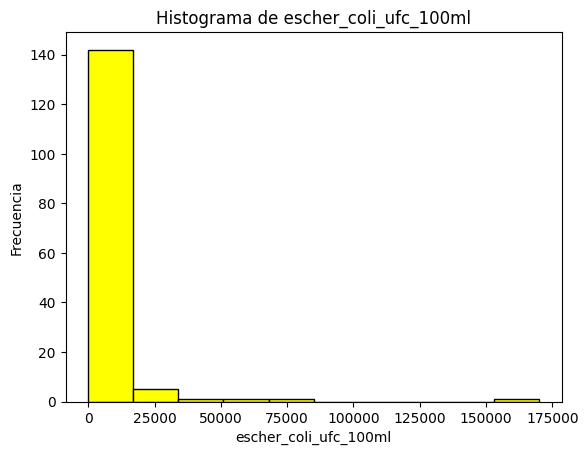

In [297]:
plt.hist(var_cont_fecal['escher_coli_ufc_100ml'], bins=10, color='yellow', edgecolor='black')


plt.xlabel('escher_coli_ufc_100ml')
plt.ylabel('Frecuencia')
plt.title('Histograma de escher_coli_ufc_100ml')
plt.show()

Vamos a chequear esto con fuentes de afuera. ¿Es logico que haya valores tan altos de esta variable?... si, puede ser por lo investigado que una parte en donde no se hace un buen tratamiento de los residuos cloacales estos terminen descargados en inmesas cantidades en el Rio.

Ahora seria bueno de alguna forma "combinar" estas tres variables para ver si podemos explicar con ellas la calidad general del agua... Para ello podemos hacer una reduccion de dimensionalidad entre las tres variables que miden la contaminacion fecal usando PCA, hacer un scaterplot de las dos primeras componentes principales y pintar los puntos de forma que muestren el nivel de calidad de agua.

De aqui sale una nueva hipotesis: La presencia de estas sustancias fecales afectan al indice de calidad de agua (ica)?

Primero par aque el algoritmo funcione correctamente vamos realizar algun tipo "data scaaling", usaremos normalizacion ya que por el histograma visto annteriormente de Escherichia coli no podemos aumir que los datos siguen una distribucion normal. De todos modos verificamos haciendo un test de Shapiro.

In [298]:
from scipy.stats import shapiro
import scipy.stats as stats

caso_1 = preprocessed_dataset["escher_coli_ufc_100ml"]
caso_2 = preprocessed_dataset["colif_fecales_ufc_100ml"]
caso_3 = preprocessed_dataset["enteroc_ufc_100ml"]


stat, p = shapiro(caso_1)
print(f"Test de Shapiro-Wilk para caso otonio: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat, p = shapiro(caso_2)
print(f"Test de Shapiro-Wilk para caso invierno: Estadístico={stat:.3f}, p-valor={p:.3f}")

stat, p = shapiro(caso_3)
print(f"Test de Shapiro-Wilk para caso primavera: Estadístico={stat:.3f}, p-valor={p:.3f}")

Test de Shapiro-Wilk para caso otonio: Estadístico=0.286, p-valor=0.000
Test de Shapiro-Wilk para caso invierno: Estadístico=0.441, p-valor=0.000
Test de Shapiro-Wilk para caso primavera: Estadístico=0.489, p-valor=0.000


Ahora no queda duda, los p quedaron menor 0.05 por lo que vamos a tener que usar normalizacion ya que los datos no siguen una distribucion normal

In [299]:
from sklearn.preprocessing import MinMaxScaler

# Crear un objeto MinMaxScaler para normalizar de 0 a 1
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(var_cont_fecal)

# Convertir a DataFrame
normalized_df = pd.DataFrame(normalized_data, columns=var_cont_fecal.columns)
print(normalized_df)

     escher_coli_ufc_100ml  colif_fecales_ufc_100ml  enteroc_ufc_100ml
0                 0.000579                 0.003993           0.007011
1                 0.012932                 0.021327           0.041796
2                 0.001168                 0.001593           0.016251
3                 0.001050                 0.001327           0.015707
4                 0.002344                 0.006660           0.000027
..                     ...                      ...                ...
146               0.001756                 0.001993           0.008098
147               0.005285                 0.007993           0.039078
148               0.002932                 0.003327           0.007555
149               0.004697                 0.005327           0.019512
150               0.002932                 0.005327           0.012446

[151 rows x 3 columns]


Antes de PCA: (151, 3)
Después de PCA: (151, 2)


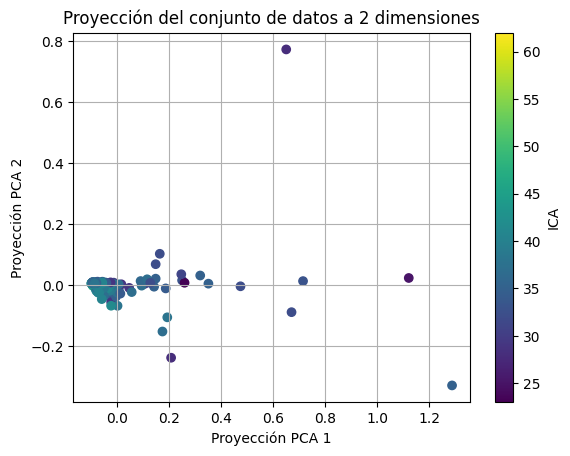

Varianza explicada por el primer componente (PCA1): 78.40%


In [300]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, whiten=False)

principalComponents = pca.fit_transform(normalized_df)
print('Antes de PCA: {}'.format(normalized_df.shape))
print('Después de PCA: {}'.format(principalComponents.shape))

plt.scatter(principalComponents[:,0], principalComponents[:,1], c=preprocessed_dataset["ica"], cmap='viridis')
plt.colorbar(label='ICA', cmap='viridis')
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección PCA 2')
plt.title('Proyección del conjunto de datos a 2 dimensiones')
plt.show()

explained_variance = pca.explained_variance_ratio_

# Varianza explicada por el primer componente (PCA1)
variance_pca1 = explained_variance[0]
print(f"Varianza explicada por el primer componente (PCA1): {variance_pca1:.2%}")

Podemos observar que no se ve muy alentador. Los puntos no siguen un patron de coloreo Por otra parte la varianza explicada por la primera componente principal es bastante alta, explica un 78% de la variacion de los datos. Veamos que pasa si estudiamos la correlacion de esta componente con la variable ica.

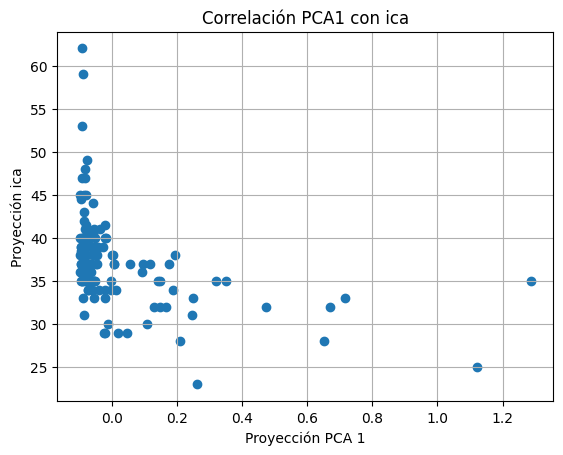

In [301]:
plt.scatter(principalComponents[:,0], preprocessed_dataset['ica'])
plt.grid(True)
plt.xlabel('Proyección PCA 1')
plt.ylabel('Proyección ica')
plt.title('Correlación PCA1 con ica')
plt.show()

Otra vez queda algo muy amorfo por lo cual nos premite creer que la calidad del agua no se puede determinar solo con las variables de contaminacion fecal. Hipotesis descartada.

Ahora intentaremos encontrar que variables predicen a nuestra variable objetivo y estrella del dataset (ica). Para ello vamos a utilizar Regresion lineal con las variables del dataset que creamos puedan a llegar a explicar a ica.

In [302]:
#variables no usadas (hidr_deriv_petr_ug_l constante)
borrar = ['sitios', 'fecha', 'hidr_deriv_petr_ug_l', 'calidad_de_agua', 'ica']

X = preprocessed_dataset.drop(borrar, axis=1)
y = preprocessed_dataset['ica']

No nos olvidamos de normalizar

In [303]:
from sklearn.preprocessing import MinMaxScaler

#estandarizar
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Ahora aplicamos Regresion Lineal sobre el nuevo conjunto de datos y la variable objetivo

In [304]:
import statsmodels.api as sm
# Agregamos una constante como característica, para estimar la ordenada al origen
X_scaled_df_ = sm.add_constant(X_scaled_df)
# Ajustamos el modelo
X_scaled_df_ = X_scaled_df_.reset_index(drop=True)
y = y.reset_index(drop=True)
model = sm.OLS(y, X_scaled_df_).fit()
# Imprimimos el resumen de los resultados
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ica   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     4.882
Date:                Wed, 13 Nov 2024   Prob (F-statistic):           2.57e-09
Time:                        13:52:18   Log-Likelihood:                -410.40
No. Observations:                 151   AIC:                             868.8
Df Residuals:                     127   BIC:                             941.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

Muchos resultados, por empezar nuestra R al cuadrado nos da '0.469' que nos dice que se estaria explicando casi el 47% de la varianza de la variable objetivo, esta bien pero aun estaria flatando varianza sin explicar.

Hacemos un QQ-plot de los residuos del modelo anterior para ver si nuestro modelo cumple con los supuestos.

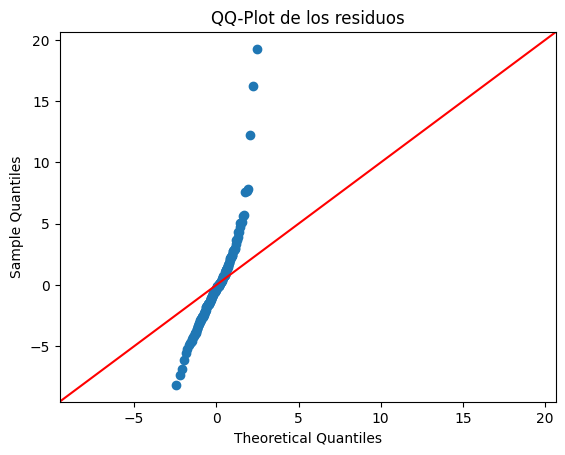

In [305]:
# QQ-Plot
sm.qqplot(model.resid, line='45')
plt.title("QQ-Plot de los residuos")
plt.show()

Como vemos no sigue una relacion lineal, esto nos esta inicando que los residuos no siguen una distribucion normal. Veamos que dice el test de Shapiro

In [306]:
from scipy.stats import shapiro

# aplicamos Shapiro-Wilk sobre los residuos
_, p = shapiro(model.resid)
print("p = %.4f" % (p))
# comparamos con el alpha
alpha = 0.05
if p > alpha:
    print("Se distribuyen normal (falló en rechazarse la hipótesis nula)")
else:
    print('No se distribuyen normal (se rechazó la hipótesis nula)')

p = 0.0000
No se distribuyen normal (se rechazó la hipótesis nula)


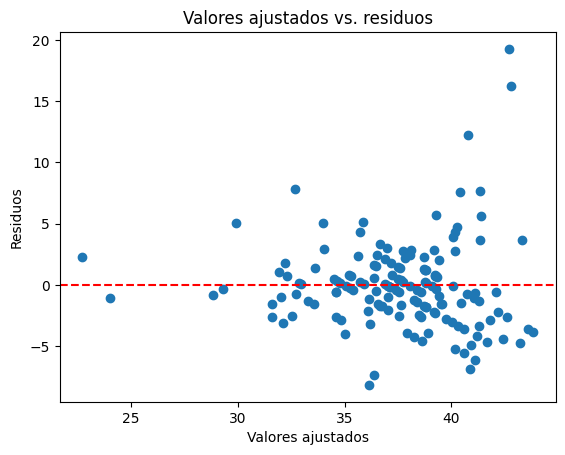

In [307]:
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Valores ajustados vs. residuos")
plt.axhline(0, color='red', linestyle='--')
plt.show()

No queda duda. Los residuos no se distribuyen de manera normal. Por ultimo veamos de cerca la distribucion que estos llevan.

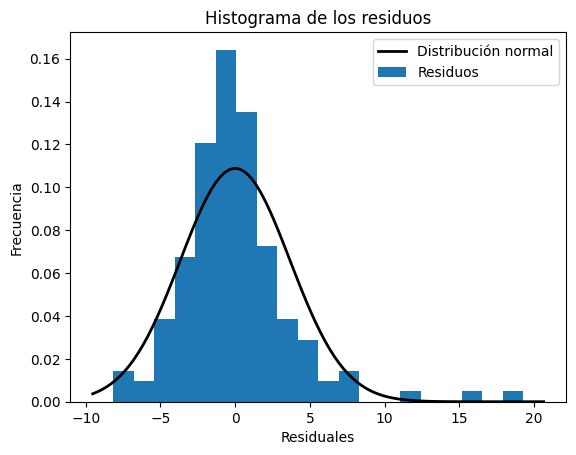

In [308]:
import numpy as np
from scipy.stats import norm

# Histograma de residuos
plt.hist(model.resid, bins=20, density=True)
# Ajustamos una curva normal a esos residuos
mu, std = norm.fit(model.resid)
# Graficamos la curva de la distribución normal
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel("Residuales")
plt.ylabel("Frecuencia")
plt.title("Histograma de los residuos")
plt.legend(["Distribución normal", "Residuos"])
plt.show()

Los residuos no se ajustan lo suficiente, eso ya nos tira abajo el modelo y por lo tanto no podemos explicar a la variable ica con la variables del dataset. Por lo menos con Regresion Lineal.